In [1]:
import matplotlib
%matplotlib inline 
# matplotlib.use('agg')
# coding: utf-8

import csv
import poppy
# get_ipython().run_line_magic('pylab', 'inline --no-import-all')
# matplotlib.rcParams['image.origin'] = 'lower'
print(poppy.__version__)

from poppy.sub_sampled_optics import Subapertures, ShackHartmannWavefrontSensor
from poppy.poppy_core import PlaneType
from matplotlib.colors import LogNorm
import poppy.fwcentroid as fwcentroid
from matplotlib import pyplot as plt

import logging
import astropy.units as u
import copy
import numpy as np
logging.getLogger('poppy').setLevel(logging.INFO)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output


/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


0.9.0


### Demonstration of POPPY ShackHartmannWavefrontSensor class

Demonstrates setup of a Shack Hartmann wavefront sensor (SHWFS) simulation. SHWFS class is based on the Subapertures class, both are located in sub_sampled_optics.py.

Simulation sets up simple optical system with deformable mirror (DM). A single actuator on the DM is poked and then measured with the Shack Hartmann wavefront sensor. 

n lenslets 10


/Users/rachelmorgan/poppy/poppy/geometry.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * r**2 * (np.arctan(y1/x) - np.arctan(y0/x))
/Users/rachelmorgan/poppy/poppy/geometry.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * r**2 * (np.arctan(y1/x) - np.arctan(y0/x))


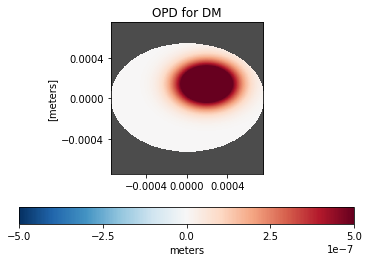

In [2]:
## Set up simulation: 

## define parameters: 
wavelength = .635e-6 #red
pixel_pitch = 2.2*u.um #both detectors have same pixel pitch 
lenslet_pitch = 150*u.um
dm_size = lenslet_pitch*10
n_lenslets=int((dm_size.to(u.m)/lenslet_pitch.to(u.m)).value)
print("n lenslets", n_lenslets)
lenslet_focal_length = .0037*u.m
pix_per_lenslet = int(lenslet_pitch/pixel_pitch)

plate_scale = 1.0*u.rad/(lenslet_focal_length*u.pix/pixel_pitch) 

## define DM
act_x = 2
act_y = 2
stroke = .3e-6
dm_actuator_pitch = dm_size/4 
dm = poppy.dms.ContinuousDeformableMirror(dm_shape=(4,4), 
    actuator_spacing=dm_actuator_pitch, radius=dm_size/2, 
    inclination_x =45)
dm.set_actuator(act_x, act_y, 2*stroke)
 #note *2 to account for reflection off of DM (OPD is 2* surface shape)

dm.display() # display optical path difference on DM

# setup flat wavefront to calculate nominal spot locations on SHWFS
wf_flat = poppy.Wavefront(diam=dm_size, wavelength=wavelength, npix=68*n_lenslets)
wf_flat *= poppy.CircularAperture(radius = dm_size/2)

# define Wavefront object for simulation, reflect off DM 
wf = poppy.Wavefront(diam=dm_size, wavelength=wavelength, npix=68*n_lenslets)
wf *= poppy.CircularAperture(radius = dm_size/2)
wf *= dm 


In [3]:
# define SHWFS object with relevant parameters

# the SHWFS simulation is a subarray of lenslets defined by the lenslet pitch and lenslet focal length. 
# The SHWFS class subsamples a wavefront according with subapertures defined by the lenslet pitch and shape, 
# then focuses each subsampled wavefront onto the detector according to the input lenslet focal length and pixel pitch.   

shwfs = ShackHartmannWavefrontSensor(lenslet_pitch= lenslet_pitch, 
               lenslet_fl=lenslet_focal_length, 
               pixel_pitch=pixel_pitch, 
               n_lenslets = n_lenslets, 
               circular = True)

In [4]:
#get flat centroids for wf reconstruction:
shwfs.sample_wf(wf_flat)
shwfs.get_psfs()
flat_centroid_list = shwfs.get_centroids()

#sample actual wf and propagate to detector: 
shwfs.sample_wf(wf)
shwfs.get_psfs()


/Users/rachelmorgan/poppy/poppy/geometry.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * r**2 * (np.arctan(y1/x) - np.arctan(y0/x))
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.


Tiling propagated wavefront arrays.


Text(0.5,1,'Single Lenslet PSF')

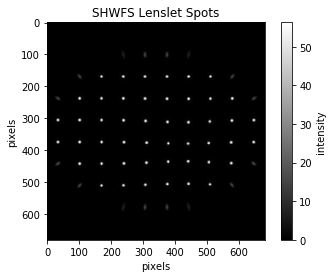

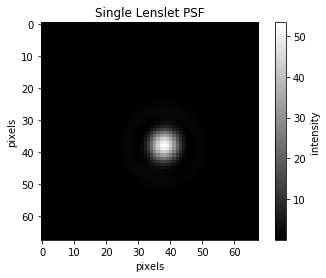

In [5]:
# retrieve and display wavefront array:
wf_array = shwfs.get_wavefront_array()
plt.figure()
plt.imshow(wf_array.intensity, cmap = 'gray')
plt.colorbar(label = 'intensity')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title("SHWFS Lenslet Spots")

# display single psf: 
single_psf = shwfs.wf_array[5,5]
plt.figure()
plt.imshow(single_psf.intensity, cmap = 'gray')
plt.colorbar(label = 'intensity')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title("Single Lenslet PSF")

In [6]:
# reconstruct wavefront using Zonal Reconstruction algorithm with the Southwell geometry 
# (currently only reconstruction method built-in to SHWFS class):
reconstruction = shwfs.reconstruct_wavefront(flat_centroid_list)

# this function calculates the centroids and computes the reconstruction based on the offset between 
# these centroids and the ones computed for a flat wavefront

Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.


Algorithm terminated at max iterations without convergence.


Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.


Algorithm terminated at max iterations without convergence.


Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.


Algorithm terminated at max iterations without convergence.


Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.
Setting centroid of aperture with no flux to NaN.


Algorithm terminated at max iterations without convergence.


Text(0.5,1,'Reconstructed Wavefront')

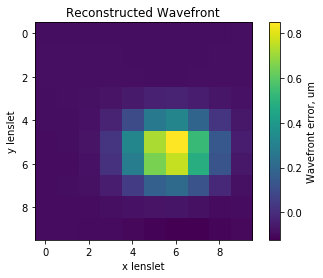

In [7]:
#display result:
plt.figure()
plt.imshow(reconstruction.value)
plt.colorbar(label = "Wavefront error, " + str(reconstruction.unit))
plt.xlabel("x lenslet")
plt.ylabel("y lenslet")
plt.title("Reconstructed Wavefront")
